In [1]:
%config InlineBackend.figure_formats = {"retina", "png"} # Mostar imágenes formato png y con alta resolución
# Las graficas se muestren en el notebook y no en una ventana emergente
%matplotlib inline

import os # Crea carpetas o rutas
import tempfile # Crea archivos o carpetas temporales que se eliminan automaticamente
from typing import List, Tuple # Anotaciones de tipo (mejora legibilidad y depuración del código)

os.environ["OPENBLAS_NUM_THREADS"] = "1" # Limita el numero de hilos1 a 1. Evita que el código use muchos nucleos y sobrecargue el sistema

# CREAR ANIMACIONES
from IPython.display import HTML, display
# display(): Muestra gráficos, animaciones, html, widgets, etc
# HTML(): Permite inscrustar código HTML directamente en la celda (para mostrar una animación)
import h5py # Lee y escribe archivos .h5, los cuales almacenan una gran cantidad de datos
from tdgl.visualization.animate import create_animation


import numpy as np
import matplotlib as mpl
from matplotlib.path import Path # Define curvas o contornos personalizados
from matplotlib.textpath import TextPath # Convierte texto en trayectorias gráficas (crea letras como curvas)
from matplotlib.font_manager import FontProperties # Permite usar fuentes específicas
import matplotlib.pyplot as plt

# CONFIGURACION DE ESTILO GRÁFICO
plt.rcParams["figure.figsize"] = (5, 4) # Tamaño de las figuras (ancho, alto)
plt.rcParams["font.size"] = 11 # Tamaño de la letra en las gráficas

# PAQUETE TDGL
import tdgl
from tdgl.geometry import box, circle, ensure_unique, close_curve
# box: Crea una caja (dominio rectangular) para la simulación
# ensure_unique: Asegura que los puntos de una curva no se repitan (importante en mallas)
# close_curve: Cierra una curva suavemente (para trayectorias cerradas como letras)
from tdgl.sources import LinearRamp, ConstantField
# LinearRamp: Campo magnetico que aumenta linealmente con el tiempo
# ConstanteField: Campo magnético constante

# PARÁMETROS DE EJECUCIÓN
USE_TEMPDIR = True # Se usará un directorio temporal para guardar imágenes si es TRUE
SAVE = True # Se guardarán las imágnes que se generen
MAKE_ANIMATIONS = True # Genera animaciones de la evolución del sistema
image_path = os.path.join(os.pardir, "images") # Define el path donde se guardarán las imágenes. os.pardir significa “directorio padre”, así que esto apunta a ../images

if USE_TEMPDIR:
    tempdir = tempfile.TemporaryDirectory()
    output_path = tempdir.name
else:
    output_path = "."

# ----------------- ANIMACIONES----------------

def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

# Geometría del dispositivo

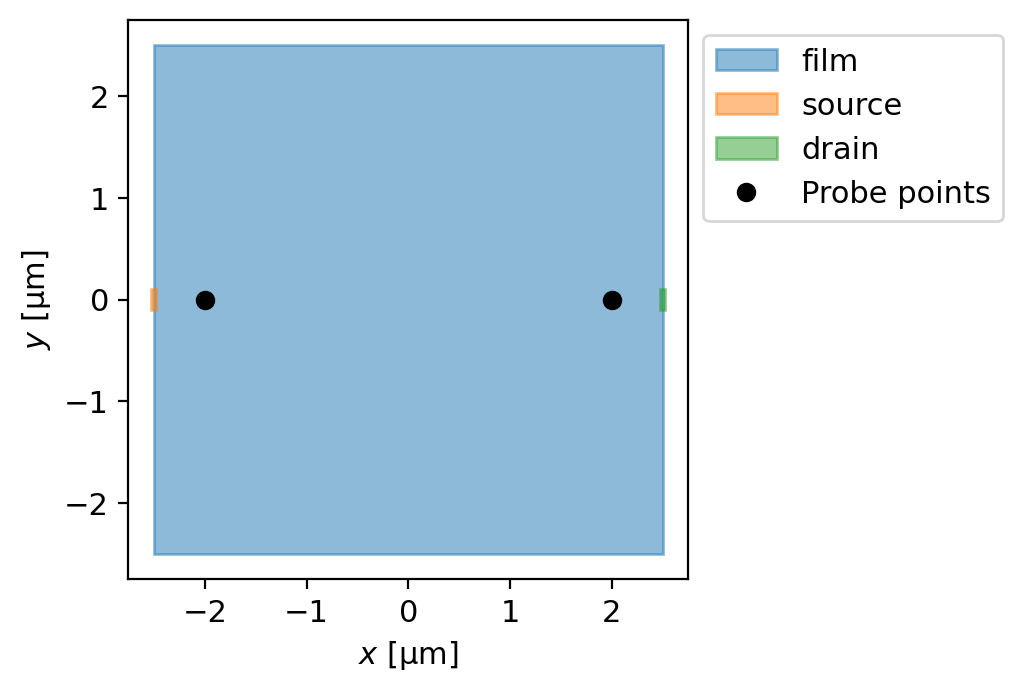

In [2]:
length_units = "um" # Longitud en micrómetros

# PARÁMETROS DEL MATERIAL
xi = 0.5 # Longitud de coherencia GL
london_lambda = 2 # Longitud de penetración de London \lambda
d = 0.1 # Espesor de la película semiconductora en micrómetros
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1) # Se crea el objeto "layer" que describe el material
# gamma = 1 -> Parámetro proporcional al inelastic scattering time y al tamaño del gap superconductor

# ------------------------------------ GEOMETRÍA ------------------------
# Device geometry
total_width = 5 # Ancho total de la película
total_length = 5 # Largo total de la película
link_width = total_width / 3 # Ancho de un canal o cuello entre las regiones

# GEOMETRÍA DEL SUPERCONDUCTOR -> Caja rectangular
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .resample(401)  # Vuelve a muestrear la curva con 401 puntos para suavizar la malla
    .buffer(0)  # Ayuda a corregir imperfecciones en los bordes del polígono
)

# TERMINALES DE CORRIENTE -> Para aplicar una corriente a travé de uno o más terminales en el dispositivo
# Terminal de corriente (como un contacto eléctrico) que se coloca arriba. Tiene el ancho del film y una altura delgada (total_length / 100)
source = (
    tdgl.Polygon("source", points=box(total_width / 100, 0.2)) # Rectángulo box(ancho, alto) -> Un poco más ancho que la película pero con altura del 1% del alto de la película
    .translate(dx=-total_length / 2)
)
# Terminal opuesto, refleja source verticalmente (yfact=-1) y renombrado como "drain"
drain = source.scale(xfact=-1).set_name("drain") # Por donde sale la corriente

#  PUNTOS DE MEDICIÓN DE VOLTAJE -> Con esto, el potencial escalar y la fase son evaluados como una función del tiempo
# Define dos puntos simétricos donde se medirá la diferencia de potencial (voltaje)
# Están ubicados sobre el eje vertical (x=0), arriba y abajo del centro de la película
probe_points = [(-2, 0), (2, 0)]

# ---------------------------MODELO DEL SUPERCONDUCTOR-------------------
# Describe la función física del dispositivo
device = tdgl.Device(
    "weak_link",
    layer=layer,
    film=film,
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

fig, ax = device.draw()

### Malla

Constructing Voronoi polygons: 100%|██████████| 2323/2323 [00:02<00:00, 950.19it/s] 


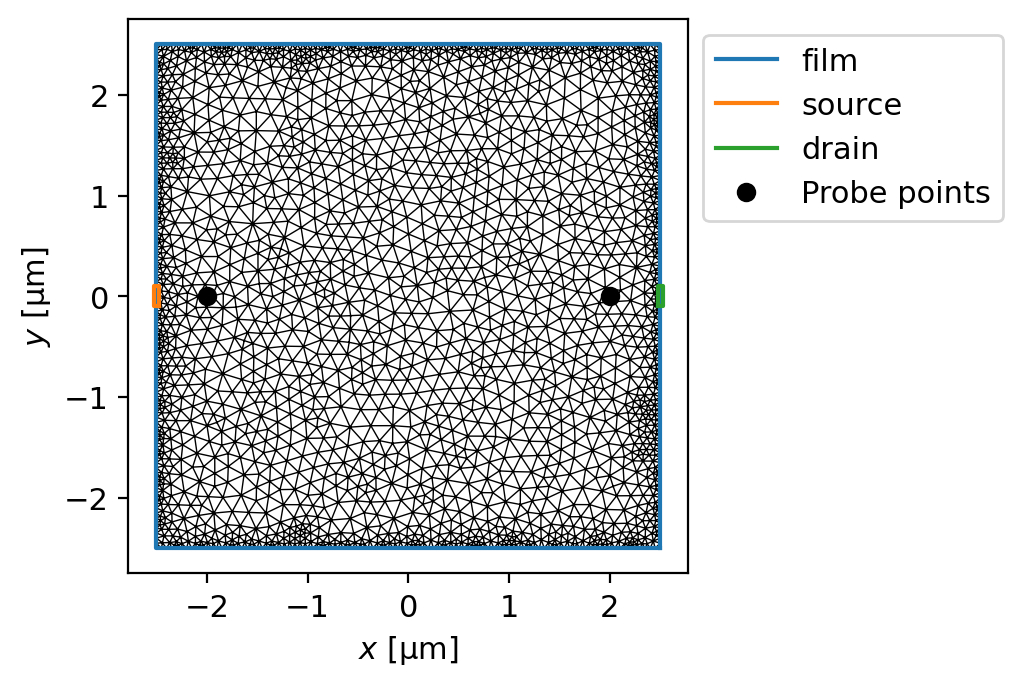

In [3]:
device.make_mesh(max_edge_length=xi / 2, smooth=100) # Genera una malla de elementos finitos que cubre el "device", la película superconductora
# smooth: Suaviza la malla, mejora la calidad geométrica de los triángulos (evita ángulos muy agudos o deformaciones). Entre mayor sea el smooth, más pasos de suavizado

# VIZUALIZAR EL DISPOSITIVO + MALLA
fig, ax = device.plot(mesh=True, legend=True)
# _ = ax.set_ylim(-3, 3)  # Ajuste rangos de los ejes

# device.mesh_stats() # Estadísticas de la malla (sites=nodos-vértices-, elements=triángulos)

# Simulating with zero applied field 
## $J \neq 0$ y $H = 0$
$J = 12 \; \mu A$ en este caso

In [12]:
options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    skip_time=100, # Simula durante 100 unidades de tiempo sin guardar datos, para que el sistema "se estabilice" antes de grabar.
    solve_time=150, # Simula otros 150 después de eso, guardando los resultados (como imágenes del sistema en diferentes momentos).
    output_file=os.path.join(tempdir.name, "Cuadrado.h5"),
    field_units = "mT",
    current_units="uA",
    save_every=100, # Solo se guarda una foto cada 100 pasos de tiempo. Así se ahorra espacio y tiempo de escritura.
)
# If you do not provide an applied_vector_potential, tdgl defaults to zero applied field.
# tdgl.solve() SOLUCIONA TDGL Y LO SIMULA
zero_field_solution = tdgl.solve( 
    device,
    options, # Son las instrucciones escritas antes
    # terminal_currents must satisfy current conservation, i.e.,
    # sum(terminal_currents.values()) == 0.
    terminal_currents=dict(source=12, drain=-12),
)

Output file already exists. Renaming to C:\Users\Angelica\AppData\Local\Temp\tmpwg82so_q\Cuadrado-2.h5.
Simulating: 100%|█████████▉| 150/150 [01:10<00:00,  2.13tau/s ]


Measured current: 11.910 µA


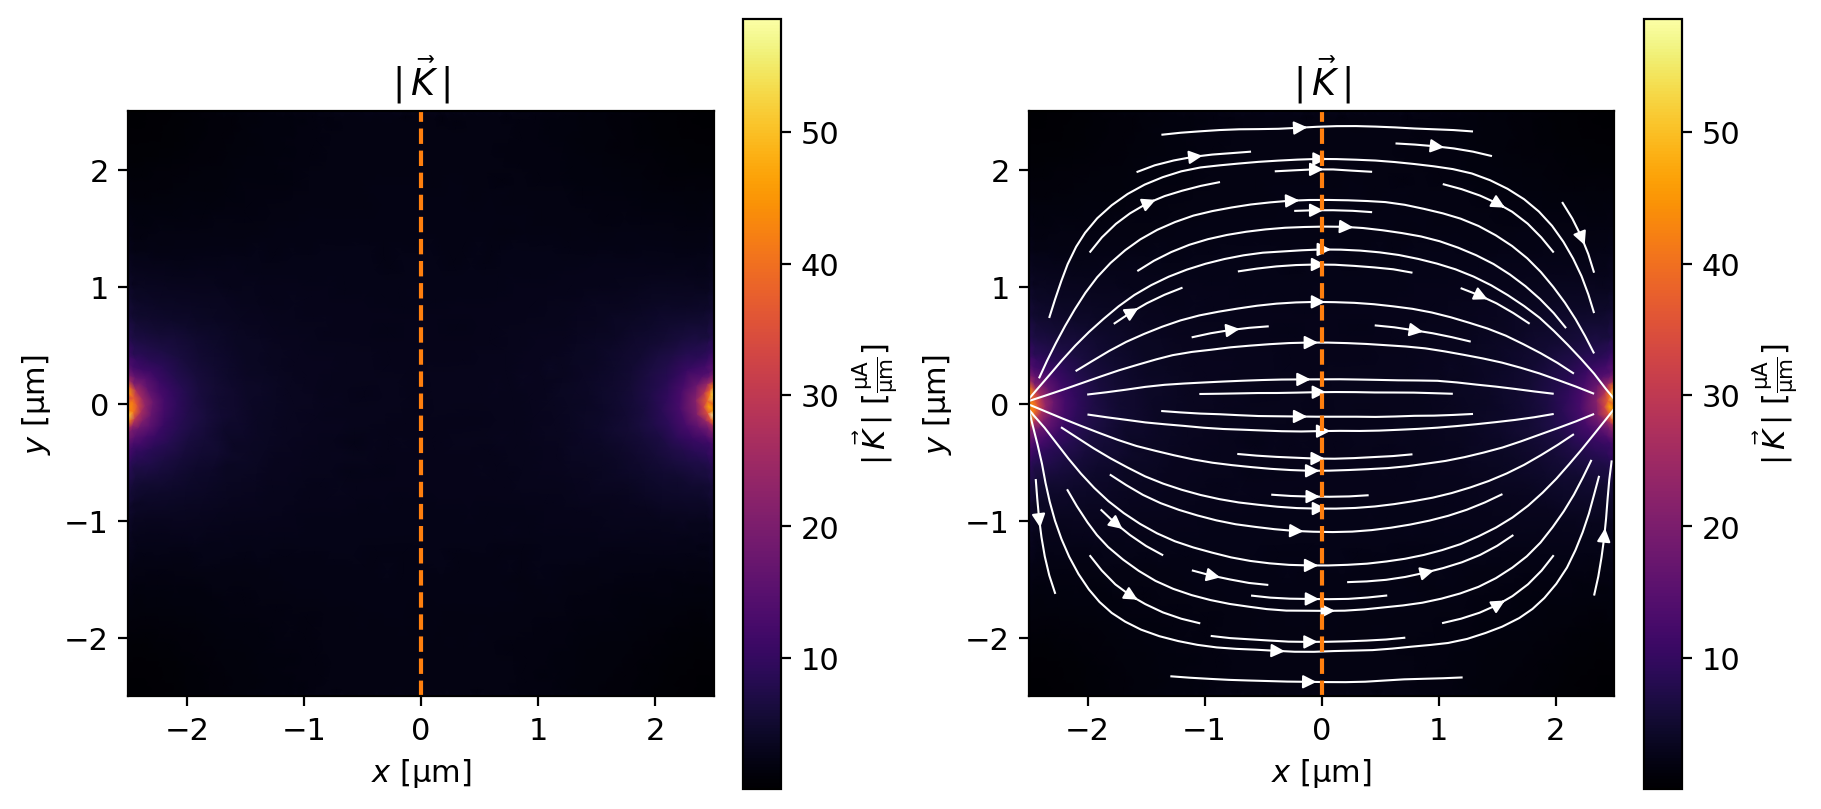

In [ ]:
# GRÁFICA QUE MUESTRA LAS CORRIENTES SUPERCONDUCTORAS EN EL DISPOSITIVO
fig, axes = plt.subplots(1, 2, figsize=(9, 4), constrained_layout = True)

_ = zero_field_solution.plot_currents(ax=axes[0], streamplot = False) # axes[0]: Vectores individuales
_ = zero_field_solution.plot_currents(ax=axes[1]) # streamplot: líneas de flujo

# Define the coordinates at which to evaluate the sheet current density
y = np.linspace(-total_width / 2, total_width / 2, 401)
x = np.zeros_like(y)

cross_section = np.array([x, y]).T

# Línea de corte "cross_section" (NARANAJA C1--) -> Dibujo de la sección transversal
for ax in axes:
    _ = ax.plot(x, y, "C1--")

# Evalúa el flujo de corriente a lo largo de la línea de corte "cross_section"
current = zero_field_solution.current_through_path(cross_section)
print(f"Measured current: {current:.3f~P}")

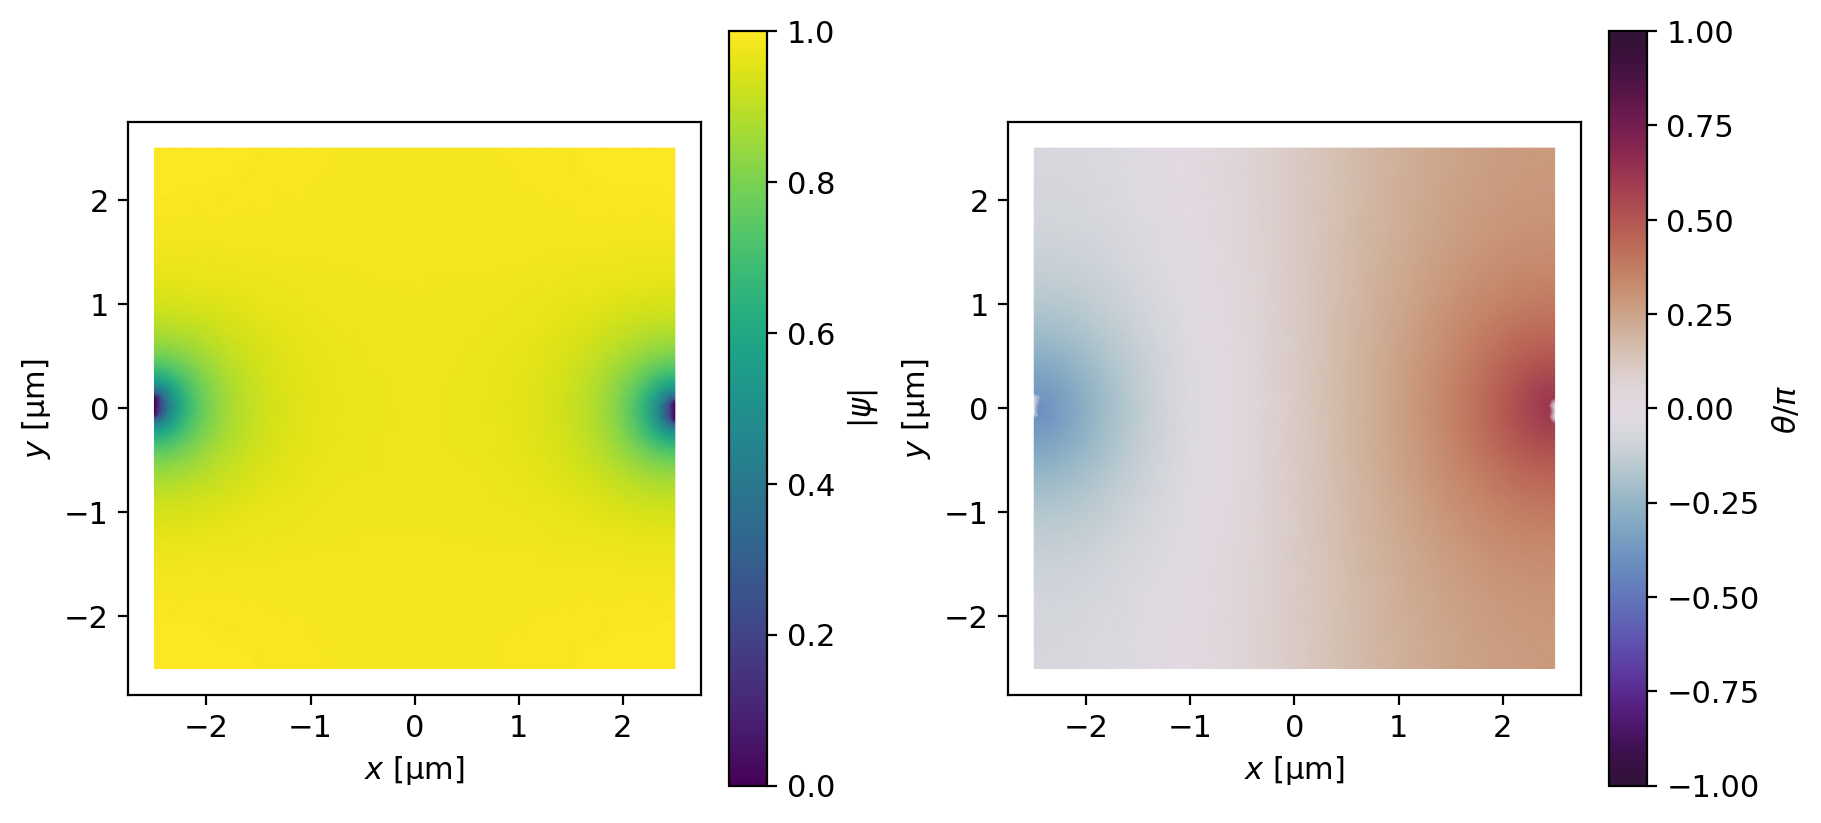

In [ ]:
# Parámetro de orden ψ en un instante específico -> t = 112
# Plot a snapshot of the order parameter in the middle of a phase slip
t0 = 112 # Este tiempo es donde se sospecha que ocurre un phase slip (\phi cambia abruptamente)
zero_field_solution.solve_step = zero_field_solution.closest_solve_step(t0)
fig, axes = zero_field_solution.plot_order_parameter(figsize=(9, 4), constrained_layout = True) # figsize(ancho, alto)

### Animación de $J \neq 0$ y $H = 0$

In [ ]:
if MAKE_ANIMATIONS:
    zero_field_video = make_video_from_solution(
        zero_field_solution,
        quantities=["order_parameter", "phase", "scalar_potential"],
        figsize=(14, 4),
    )
    display(zero_field_video) # Muestra el video generado